## Assignment 3.1. Sequence Classification

## Task 1.2: Aspect-level Sentiment Classification

Build an attention-based aspect-level sentiment classification model with RNN. Your model shall
include:

- RNN network that learns sentence representation from input sequences.
- Attention network that assigns attention score over a sequence of RNN hidden states based on aspect terms representation.
- Fully connected network that predicts sentiment label, given the representation weighted by the attention score.

Train the model by using data iterator and batch generator. Evaluate the trained model on
the provided test set.

### ==> Domain name used: yelp14

Instead of lt14, we have used yelp14 for both document and aspect classification.

In [0]:
# Dimensions based on the domain name: yelp14!!!
overal_maxlen = 74
overal_maxlen_aspect = 18

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
# Absolute path
absolute_path = '/content/drive/My Drive/TUE -EIT (me)/Recommender Systems/Assignment 3 - Sequential networks/Aspect Level/'
aspect_path = absolute_path + 'data/aspect_level-sentiment/aspect_level'

In [0]:
import os
import sys
import codecs
import operator
import numpy as np
import re
from time import time
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')

import _pickle as cPickle

In [0]:
# Read pickel files

def read_pickle(data_path, file_name):

    f = open(os.path.join(data_path, file_name), 'rb')
    read_file = cPickle.load(f)
    f.close()

    return read_file

def save_pickle(data_path, file_name, data):

    f = open(os.path.join(data_path, file_name), 'wb')
    cPickle.dump(data, f)
    print(" file saved to: %s"%(os.path.join(data_path, file_name)))
    f.close()
    
vocab = read_pickle(aspect_path, 'all_vocab.pkl')

train_x = read_pickle(aspect_path, 'train_x.pkl')
train_y = read_pickle(aspect_path, 'train_y.pkl')
dev_x = read_pickle(aspect_path, 'dev_x.pkl')
dev_y = read_pickle(aspect_path, 'dev_y.pkl')
test_x = read_pickle(aspect_path, 'test_x.pkl')
test_y = read_pickle(aspect_path, 'test_y.pkl')

train_aspect = read_pickle(aspect_path, 'train_aspect.pkl')
dev_aspect = read_pickle(aspect_path, 'dev_aspect.pkl')
test_aspect = read_pickle(aspect_path, 'test_aspect.pkl')

In [0]:
# Data iterator 
class Dataiterator():
    '''
      1) Iteration over minibatches using next(); call reset() between epochs to randomly shuffle the data
      2) Access to the entire dataset using all()
    '''
    
    def __init__(self, aspect_data, seq_length=32, decoder_dim=300, batch_size=32):
        
        len_aspect_data = len(aspect_data[0])
                
        self.X_aspect = aspect_data[0] 
        self.y_aspect = aspect_data[1]
        self.aspect_terms = aspect_data[2]
        
        self.num_data = len_aspect_data
        self.batch_size = batch_size # batch size
        self.reset() # initial: shuffling examples and set index to 0
    
    def __iter__(self): # iterates data
        return self


    def reset(self): # initials
        self.idx = 0
        self.order = np.random.permutation(self.num_data) # shuffling examples by providing randomized ids 
        
    def __next__(self): # return model inputs - outputs per batch
        
        X_ids = [] # hold ids per batch 
        while len(X_ids) < self.batch_size:
            X_id = self.order[self.idx] # copy random id from initial shuffling
            X_ids.append(X_id)
            self.idx += 1 # 
            if self.idx >= self.num_data: # exception if all examples of data have been seen (iterated)
                self.reset()
                raise StopIteration()
                
        batch_X_aspect = self.X_aspect[np.array(X_ids)] # X values (encoder input) per batch
        batch_y_aspect = self.y_aspect[np.array(X_ids)] # y_in values (decoder input) per batch
        batch_aspect_terms = self.aspect_terms[np.array(X_ids)]      
        
        return batch_X_aspect, batch_aspect_terms, batch_y_aspect

          
    def all(self): # return all data examples
        return self.X_aspect, self.aspect_terms, self.y_aspect

## Model

In [0]:
from keras.models import Model
from keras.layers import Input, Embedding, Dense, Lambda, Dropout, LSTM
from keras.layers import Reshape, Activation, RepeatVector, concatenate, Concatenate, Dot, Multiply

import keras.backend as K
from keras.engine.topology import Layer
from keras import initializers
from keras import regularizers
from keras import constraints

import keras.optimizers as opt
from keras.callbacks import EarlyStopping, ModelCheckpoint

In [0]:
K.clear_session()

### Attention Network

In [0]:
def custom_softmax(x, axis=1):
            """Softmax activation function.
            # Arguments
                x : Tensor.
                axis: Integer, axis along which the softmax normalization is applied.
            # Returns
                Tensor, output of softmax transformation.
            # Raises
                ValueError: In case `dim(x) == 1`.
            """
            ndim = K.ndim(x)
            if ndim == 2:
                return K.softmax(x)
            elif ndim > 2:
                e = K.exp(x - K.max(x, axis=axis, keepdims=True))
                s = K.sum(e, axis=axis, keepdims=True)
                return e / s
            else:
                raise ValueError('Cannot apply softmax to a tensor that is 1D')

In [0]:
repeator = RepeatVector(overal_maxlen, name='repeator_att')
concatenator = Concatenate(axis=-1, name='concator_att')
densor1 = Dense(300, activation = "tanh", name='densor1_att')
densor2 = Dense(1, activation = "relu", name='densor2_att')
activator = Activation(custom_softmax, name='attention_weights')
dotor = Dot(axes = 1, name='dotor_att')

In [0]:
def attention(keys, query):
    
    query = repeator(query)
    print("query shape: %s" %str(query._keras_shape))
    concat = concatenator([keys, query])
    print("concat shape: %s" %str(concat._keras_shape))
    e1 = densor1(concat)
    print("e1 shape: %s" %str(e1._keras_shape))
    e2 = densor2(e1)
    print("e2 shape: %s" %str(e2._keras_shape))
    alphas = activator(e2)
    print("alphas shape: %s" %str(alphas._keras_shape))
    context = dotor([alphas, keys])
    print("context shape: %s" %str(context._keras_shape))
    
    return context, alphas

In [0]:
class Average(Layer):
  
    def __init__(self, mask_zero=True, **kwargs):
        self.mask_zero = mask_zero
        self.supports_masking = True
        super(Average, self).__init__(**kwargs)

    def call(self, x, mask=None):
        if self.mask_zero:
            mask = K.cast(mask, K.floatx())
            mask = K.expand_dims(mask)
            x = x * mask
            return K.sum(x, axis=1) / (K.sum(mask, axis=1) + K.epsilon())
        else:
            return K.mean(x, axis=1)

    def compute_output_shape(self, input_shape):
        return (input_shape[0], input_shape[-1])
    
    def compute_mask(self, x, mask):
        return None

### Main model

In [0]:
# Network parameters
dropout_prev_LSTM = 0.3
dropout = 0.5     
recurrent_dropout = 0.4
vocab_size = len(vocab)
num_outputs = 3 # labels
early_stopping_patience = 5

In [21]:
# inputs
sentence_input = Input(shape=(overal_maxlen,), dtype='int32', name='sentence_input')
aspect_input = Input(shape=(overal_maxlen_aspect,), dtype='int32', name='aspect_input')

# word embedding layer
word_emb = Embedding(vocab_size, 300, mask_zero=True, name='word_emb')

# aspect-level representation
aspect_term_embs = word_emb(aspect_input)
aspect_embs = Average(mask_zero=True, name='aspect_emb')(aspect_term_embs)

# sentence-level representation from two domains
sentence_embs = word_emb(sentence_input)

# LSTM layer
dropout_mid = Dropout(dropout_prev_LSTM)
dropout_lstm = dropout_mid(sentence_embs)
rnn = LSTM(300, return_sequences=True, dropout=dropout, recurrent_dropout=recurrent_dropout, name='lstm')
sentence_lstm = rnn(dropout_lstm)

# attention context
att_context, att_weights = attention(sentence_lstm, aspect_embs)

# fully_connected = Dense(300, name='fully_connected')(att_context)
sentence_output = Dense(num_outputs, name='dense_1')(att_context)
sentence_output = Reshape((num_outputs,))(sentence_output)

# Aspect probabilities
aspect_probs = Activation('softmax', name='aspect_model')(sentence_output)

# Model
model = Model(inputs=[sentence_input, aspect_input], outputs=[aspect_probs])

# optimizer
optimizer = opt.RMSprop(lr=0.001, rho=0.9, epsilon=1e-06, clipnorm=10, clipvalue=0)
model.compile(optimizer=optimizer,
              loss={'aspect_model': 'categorical_crossentropy'},
              loss_weights = {'aspect_model': 1},
              metrics = {'aspect_model': 'categorical_accuracy'})

query shape: (None, 74, 300)
concat shape: (None, 74, 600)
e1 shape: (None, 74, 300)
e2 shape: (None, 74, 1)
alphas shape: (None, 74, 1)
context shape: (None, 1, 300)


In [22]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
sentence_input (InputLayer)     (None, 74)           0                                            
__________________________________________________________________________________________________
aspect_input (InputLayer)       (None, 18)           0                                            
__________________________________________________________________________________________________
word_emb (Embedding)            multiple             3000900     aspect_input[0][0]               
                                                                 sentence_input[0][0]             
__________________________________________________________________________________________________
dropout_2 (Dropout)             (None, 74, 300)      0           word_emb[1][0]                   
__________

### Training

In [0]:
# Train and Validation batches
batch_size = 32

train_steps_epoch = len(train_x)/batch_size
batch_train_iter = Dataiterator([train_x, train_y, train_aspect], batch_size)

val_steps_epoch = len(dev_x)/batch_size
batch_val_iter = Dataiterator([dev_x, dev_y, dev_aspect], batch_size)

In [0]:
# Train Generator

def train_generator(model, batch_train_iter, batch_val_iter):
    
    earlystop_callbacks = [EarlyStopping(monitor='val_loss', patience=early_stopping_patience),
                     ModelCheckpoint(filepath=os.path.join('./','{epoch:02d}-{loss:.2f}.check'), \
                                     monitor='val_loss', save_best_only=False, \
                                     save_weights_only=True)
                     ]
    
    def train_gen():
        while True:
            train_batches = [[[X, aspect], [y]] for X, aspect, y in batch_train_iter]
            for train_batch in train_batches:
                yield train_batch
                
    def val_gen():
        while True:
            val_batches = [[[X, aspect], [y]] for X, aspect, y in batch_val_iter]
            for val_batch in val_batches:
                yield val_batch
                
    history = model.fit_generator(train_gen(), validation_data=val_gen(), \
                                  validation_steps=val_steps_epoch, steps_per_epoch=train_steps_epoch, \
                                  epochs = 20, callbacks = earlystop_callbacks)
    
    return history
      

In [0]:
history = train_generator(model, batch_train_iter, batch_val_iter)

Epoch 1/20
91/90 [==============================] - 34s 373ms/step - loss: 0.9011 - categorical_accuracy: 0.6027 - val_loss: 0.7663 - val_categorical_accuracy: 0.6766
Epoch 2/20
91/90 [==============================] - 31s 339ms/step - loss: 0.7357 - categorical_accuracy: 0.6748 - val_loss: 0.7596 - val_categorical_accuracy: 0.6848
Epoch 3/20
91/90 [==============================] - 31s 340ms/step - loss: 0.6452 - categorical_accuracy: 0.7376 - val_loss: 0.8386 - val_categorical_accuracy: 0.6617
Epoch 4/20
91/90 [==============================] - 30s 326ms/step - loss: 0.5768 - categorical_accuracy: 0.7747 - val_loss: 0.7692 - val_categorical_accuracy: 0.6807
Epoch 5/20
91/90 [==============================] - 32s 351ms/step - loss: 0.5201 - categorical_accuracy: 0.7977 - val_loss: 0.7260 - val_categorical_accuracy: 0.6984
Epoch 6/20
91/90 [==============================] - 30s 330ms/step - loss: 0.4708 - categorical_accuracy: 0.8290 - val_loss: 0.7895 - val_categorical_accuracy: 0.679

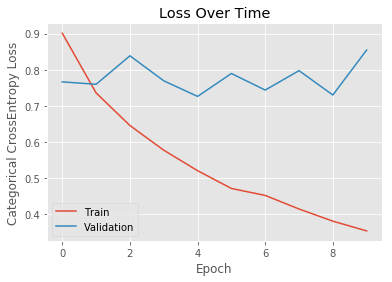

In [0]:
# Printing the Loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.xlabel('Epoch')
plt.ylabel('Categorical CrossEntropy Loss')
plt.title('Loss Over Time')
plt.legend(['Train','Validation'])

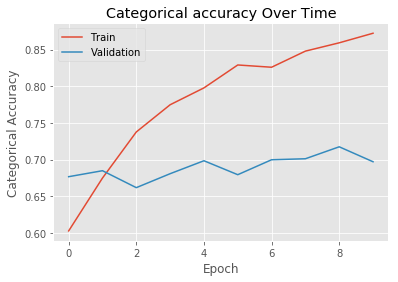

In [0]:
# Printing the Accuracy
plt.plot(history.history['categorical_accuracy'])
plt.plot(history.history['val_categorical_accuracy'])

plt.xlabel('Epoch')
plt.ylabel('Categorical Accuracy')
plt.title('Categorical accuracy Over Time')
plt.legend(['Train','Validation'])

### Evaluate

In [0]:
# Evaluation on test set
test_loss, test_acc = model.evaluate([test_x, test_aspect], [test_y], verbose = 2, batch_size = 32)
print("test_loss: %.2f" % (test_loss))
print("test_acc: %.2f" % (test_acc))


test_loss: 0.76
test_acc: 0.70


As we can observe in the Loss and Accuracy curves, we have in the Validation set an erratic behaviour due to the lack of data. We have tried different techniques such as adding extra Dropout layers or increasing the dropout rate which have not improved these curves. The accuracy obtained in the Aspect-level one is a bit lower compared to the Document one, however the computation time is approximately one-third of the Document-level. This is basically because of the smaller amount of data needed in the Aspect-level training.